In [ ]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df=pd.read_csv('/content/emails.csv')

In [ ]:
df.head()

,subject,body,label
0,Happy Friday! 😊,Hope you have a relaxing weekend ahead!,Low
1,Budget Plan for Next Quarter,Don’t forget tomorrow’s training session on co...,Medium
2,Meeting Required ASAP,Please join the urgent meeting at 2 PM. It’s a...,High
3,Critical Issue with Client Delivery,Suspicious login detected. Please reset your p...,High
4,Meeting Required ASAP,Action is needed immediately to fix a major pr...,High


In [ ]:
df['text'] = df['subject'].fillna('')+" "+df['body'].fillna('')

In [ ]:
df['text'] = df['text'].str.lower()

In [ ]:
def clean_text(text):
  lemmatizer = WordNetLemmatizer() # Initialize the lemmatizer
  text = re.sub(f"[{string.punctuation}0-9]","",text)
  tokens = nltk.word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  tokens=[lemmatizer.lemmatize(w) for w in tokens]
  return " ".join(tokens)

In [ ]:
df['clean_text']=df['text'].apply(clean_text)#aply cleaning

In [ ]:
df[['subject','label','clean_text']].head()

,subject,label,clean_text
0,Happy Friday! 😊,Low,happy friday 😊 hope you have a relaxing weeken...
1,Budget Plan for Next Quarter,Medium,budget plan for next quarter don ’ t forget to...
2,Meeting Required ASAP,High,meeting required asap please join the urgent m...
3,Critical Issue with Client Delivery,High,critical issue with client delivery suspicious...
4,Meeting Required ASAP,High,meeting required asap action is needed immedia...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000,#limit to top 1000 words
                              ngram_range=(1,2),#Include unigrams and bigrams
                             stop_words='english') #Buit_in stopword removal

In [ ]:
X=vectorizer.fit_transform(df['clean_text']) #fit and transform the cleant text

In [ ]:
#convert to dataframe (for inspection)
tfidf_df=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

In [ ]:
tfidf_df.head()

,act,act resolve,action,action needed,afternoon,agenda,agenda week,ahead,alert,alert change,...,week review,weekend,weekend ahead,weekend deal,weekend sale,weekly,weekly report,weekly status,workplace,workplace productivity
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.31192,0.0,0.0,...,0.0,0.217882,0.31192,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.215082,0.215082,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
y=label_encoder.fit_transform(df['label'])
label_mapping=dict(zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_)))
print("Label mapping:",label_mapping)


Label mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
#Logistic regression
log_reg=LogisticRegression(max_iter=1000)
log_reg.fit(X_train,y_train)
y_pred_lr=log_reg.predict(X_test)

In [ ]:
print(" Logistic Regression report:",
   classification_report(y_test,y_pred_lr,target_names=label_encoder.classes_))

 Logistic Regression report:               precision    recall  f1-score   support

        High       1.00      1.00      1.00         4
         Low       1.00      1.00      1.00         7
      Medium       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [ ]:
#Random Forest
rf_model=RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train,y_train)
y_pred_rf=rf_model.predict(X_test)

In [ ]:
print("Random Forest Report:")
print(classification_report(y_test,y_pred_rf,target_names=label_encoder.classes_))

Random Forest Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         4
         Low       1.00      1.00      1.00         7
      Medium       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



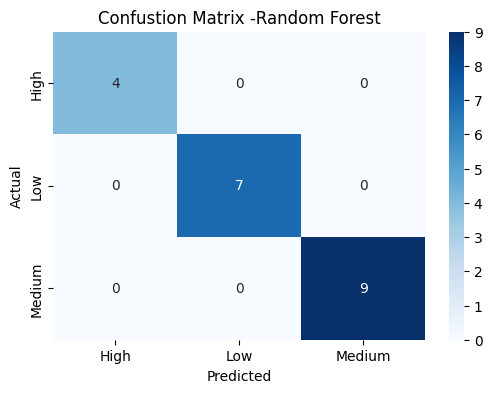

In [ ]:
cm=confusion_matrix(y_test,y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Confustion Matrix -Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
import numpy as np

In [ ]:
#match words to importance
feature_names=vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_

In [ ]:
feat_df = pd.DataFrame({'feature':feature_names,
                        'importance':importances})

In [ ]:
top_feats=feat_df.sort_values(by='importance',ascending=False).head(20)

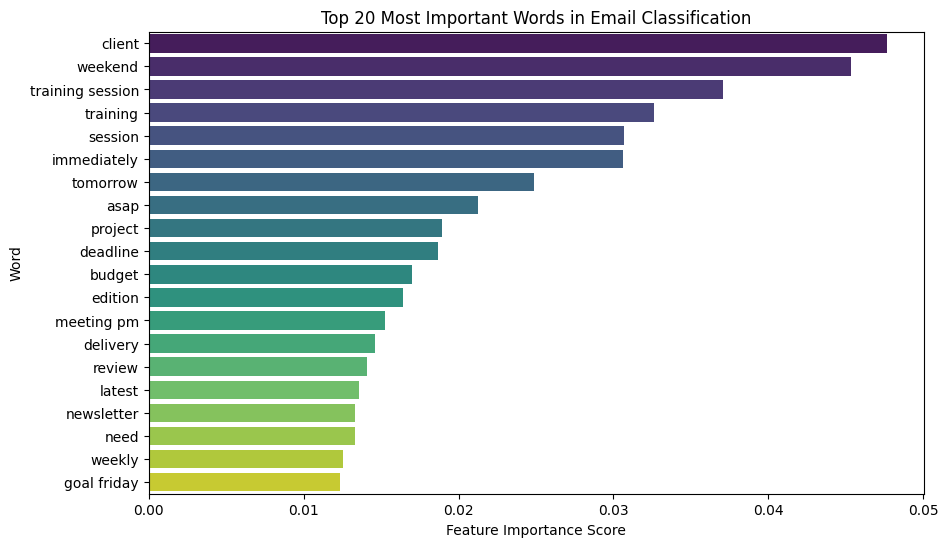

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_feats,x='importance',y='feature',palette='viridis')
plt.title("Top 20 Most Important Words in Email Classification")
plt.xlabel("Feature Importance Score")
plt.ylabel("Word")
plt.show()

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pickle

# Save Random Forest model
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# Save TF-IDF vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Save Label Encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [ ]:
import streamlit as st
import pickle
import nltk
import string
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load components
rf_model = pickle.load(open("rf_model.pkl", "rb"))
vectorizer = pickle.load(open("vectorizer.pkl", "rb"))
label_encoder = pickle.load(open("label_encoder.pkl", "rb"))

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}0-9]", " ", text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

# Streamlit UI
st.title("📧 Email Priority Predictor")
st.write("Paste an email subject and body, and I'll tell you how important it is!")

subject = st.text_input("📌 Subject")
body = st.text_area("📝 Email Body")

if st.button("Predict Priority"):
    full_text = subject + " " + body
    cleaned = clean_text(full_text)
    vectorized = vectorizer.transform([cleaned])
    prediction = rf_model.predict(vectorized)
    label = label_encoder.inverse_transform(prediction)[0]

    st.success(f"🟢 **Predicted Priority:** `{label}`")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2025-07-03 15:56:10.050 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 15:56:10.214 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-03 15:56:10.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 15:56:10.219 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 15:56:10.222 Thread 'MainThread': missing ScriptRunContext! This warn

In [ ]:
!streamlit run /content/app_e.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.150.185.119:8501



In [ ]:
!streamlit run /content/app_e.py